# Sorted AML Fractions - LSC Activity

In [1]:
import sys 
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)

In [3]:
def load_fractions(dem_path):
    # load CIBERSORT output
    dat = sc.read_csv(dem_path, first_column_names=True)
    dat = dat[:,~dat.var_names.isin(['P-value', 'Correlation', 'RMSE', 'Absolute score (sig.score)'])]
    dat.obs.index.rename('Sample', inplace=True)

    # Absolute Scores
    absolute_scores = dat.to_df()
    absolute_scores.columns = absolute_scores.columns+'-Absolute'
    dat.obs = dat.obs.merge(absolute_scores, how = 'left', left_index=True, right_index=True)
    
    # Relative Scores (tumor only)
    relative_scores = dat.to_df()
    relative_scores = relative_scores.iloc[:,~relative_scores.columns.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
    relative_scores = (relative_scores.transpose() / relative_scores.sum(axis=1).transpose()).transpose()
    relative_scores.columns = relative_scores.columns+'-Relative'
    dat.obs = dat.obs.merge(relative_scores, how = 'left', left_index=True, right_index=True)
    
    return dat

In [2]:
from seaborn.categorical import _ViolinPlotter

class MyVPlot(_ViolinPlotter):
    def draw_quartiles(self, ax, data, support, density, center, split=False):
        """Draw the quartiles as lines at width of density."""
        q25, q50, q75 = np.percentile(data, [25, 50, 75])
        self.draw_to_density(ax, center, q50, support, density, split,
                             linewidth=self.linewidth, )

def my_violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
                  bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
                  width=.8, inner="box", split=False, dodge=True, orient=None,
                  linewidth=None, color=None, palette=None, saturation=.75,
                  ax=None, **kwargs):
    plotter = MyVPlot(x, y, hue, data, order, hue_order,
                      bw, cut, scale, scale_hue, gridsize,
                      width, inner, split, dodge, orient, linewidth,
                      color, palette, saturation)
    if ax is None:
        ax = plt.gca()
    plotter.plot(ax)
    return ax

def violin_category(data, category, score, xlab = None, ylab = None, order=["Low", "High"], boxpairlist=[("Low", "High")], textformat = "star", swarm=True, swarmsize=5):
    data = data.obs
    p1 = my_violinplot(data = data, x = category, y = score, scale='width', order=order, inner="quartile")
    if swarm==True:
        p1 = sns.swarmplot(data = data, x = category, y = score, order=order, color="black", size = swarmsize)
    add_stat_annotation(p1, data=data, x= category, y= score, order=order, box_pairs=boxpairlist,
                        test='t-test_ind', text_format= textformat, loc='outside', verbose=0)
    if xlab != None:
        plt.xlabel(xlab)
    if ylab != None:
        plt.ylabel(ylab)
    sns.despine()

In [4]:
%%R -w 8 -h 4 --units in -r 200
require("survival")
library(tidyverse)
library(ggpubr)
library(survminer)

R[write to console]: Loading required package: survival

R[write to console]: Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Functionally Validated LSC Fractions

In [5]:
lsc = load_fractions('Data/Fig1_SingleCell_LSC/CIBERSORTx_LSC_Fractions.csv')
# Get Coldata
anno = pd.read_csv("Data/Fig1_SingleCell_LSC/LSC_frequencies.csv")
anno['ID'] = anno['Sample'] + "_" + anno['fraction']    
anno = anno.set_index('ID') 

# Replace LSC Fraction names 
lsc.obs_names = lsc.obs_names.str.replace('_Bl', '')
lsc.obs = lsc.obs.merge(anno, how='left', left_index=True, right_index=True)
lsc.obs

,B-Absolute,CTL-Absolute,GMP-like-Absolute,LSPC-Cycle-Absolute,LSPC-Primed-Absolute,LSPC-Quiescent-Absolute,Mono-like-Absolute,Monocyte-Absolute,NK-Absolute,Plasma-Absolute,...,cDC-like-Relative,Sample,Patient,fraction,samp_frac,LSC status,uniqueID,LSC_Frequency,frequency_cat,new_frequency_cat
LSC0001_CD34mCD38m,0.424229,0.019086,0.238961,18.795918,0.401809,0.206428,0.474813,1.447356,0.233423,0.069807,...,0.107466,LSC0001,90295,CD34mCD38m,LSC0001_CD34mCD38m,-,A5_b2,NE,NE,NE
LSC0001_CD34pCD38m,0.137161,0.892244,5.945861,1.027860,1.377448,2.679355,0.000000,0.398436,0.019347,0.148736,...,0.202942,LSC0001,90295,CD34pCD38m,LSC0001_CD34pCD38m,+,A2_b2,7213,med,med-high
LSC0001_CD34pCD38p,0.079102,0.528855,8.309251,1.530146,0.104221,1.354740,0.000000,0.399566,0.020331,0.118868,...,0.114067,LSC0001,90295,CD34pCD38p,LSC0001_CD34pCD38p,-,A3.3_b2,NE,NE,NE
LSC0002_CD34mCD38p,1.090392,0.949458,1.163102,4.258364,1.577820,0.000000,15.519322,1.874642,0.352317,0.636757,...,0.077147,LSC0002,90716,CD34mCD38p,LSC0002_CD34mCD38p,-,B4_b2,NE,NE,NE
LSC0002_CD34pCD38m,0.204275,0.751188,7.265747,0.233498,0.043451,4.017636,0.000000,0.821984,0.013215,0.325132,...,0.164699,LSC0002,90716,CD34pCD38m,LSC0002_CD34pCD38m,+,B2_b2,"43,681",med,med-high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSC0074_CD34pCD38p,0.209141,0.482849,6.263955,2.869937,1.804481,0.554446,0.278477,1.066228,0.011712,0.165253,...,0.083318,LSC0074,110500,CD34pCD38p,LSC0074_CD34pCD38p,+,I10_b4,"less than 10,000 (probably much less)",NaN,NaN
LSC0076_CD34mCD38m,2.172230,1.129160,0.053284,0.598986,0.106550,1.111063,0.708282,6.191735,0.000000,0.133446,...,0.802525,LSC0076,90686,CD34mCD38m,LSC0076_CD34mCD38m,-,G13_b4,NE,NE,NE
LSC0076_CD34mCD38p,0.652221,0.989573,2.001715,2.273849,0.448300,0.000000,7.026440,1.295971,0.482887,0.385136,...,0.370512,LSC0076,90686,CD34mCD38p,LSC0076_CD34mCD38p,-,F13_b4,NE,NE,NE
LSC0077_CD34pCD38m,0.107347,0.715121,0.007726,1.773734,6.111110,2.185036,0.000000,0.385111,0.000000,0.064289,...,0.084663,LSC0077,110484,CD34pCD38m,LSC0077_CD34pCD38m,+,C12_b4,4170,high,high


### Plot cell type enrichment across CD34 and CD38 fractions

In [6]:
lsc.obs['Fraction'] = np.where(lsc.obs.fraction == 'CD34pCD38m', '34+ 38-', np.where(lsc.obs.fraction == 'CD34pCD38p', '34+ 38+',
                                  np.where(lsc.obs.fraction == 'CD34mCD38p', '34- 38+', np.where(lsc.obs.fraction == 'CD34mCD38m', '34- 38-', 'NA'))))
lsc.obs['Fraction'] = lsc.obs['Fraction'].astype('category').cat.set_categories(['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'])

/Users/andyzeng/opt/anaconda3/envs/singlecell/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/andyzeng/opt/anaconda3/envs/singlecell/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/andyzeng/opt/anaconda3/envs/singlecell/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


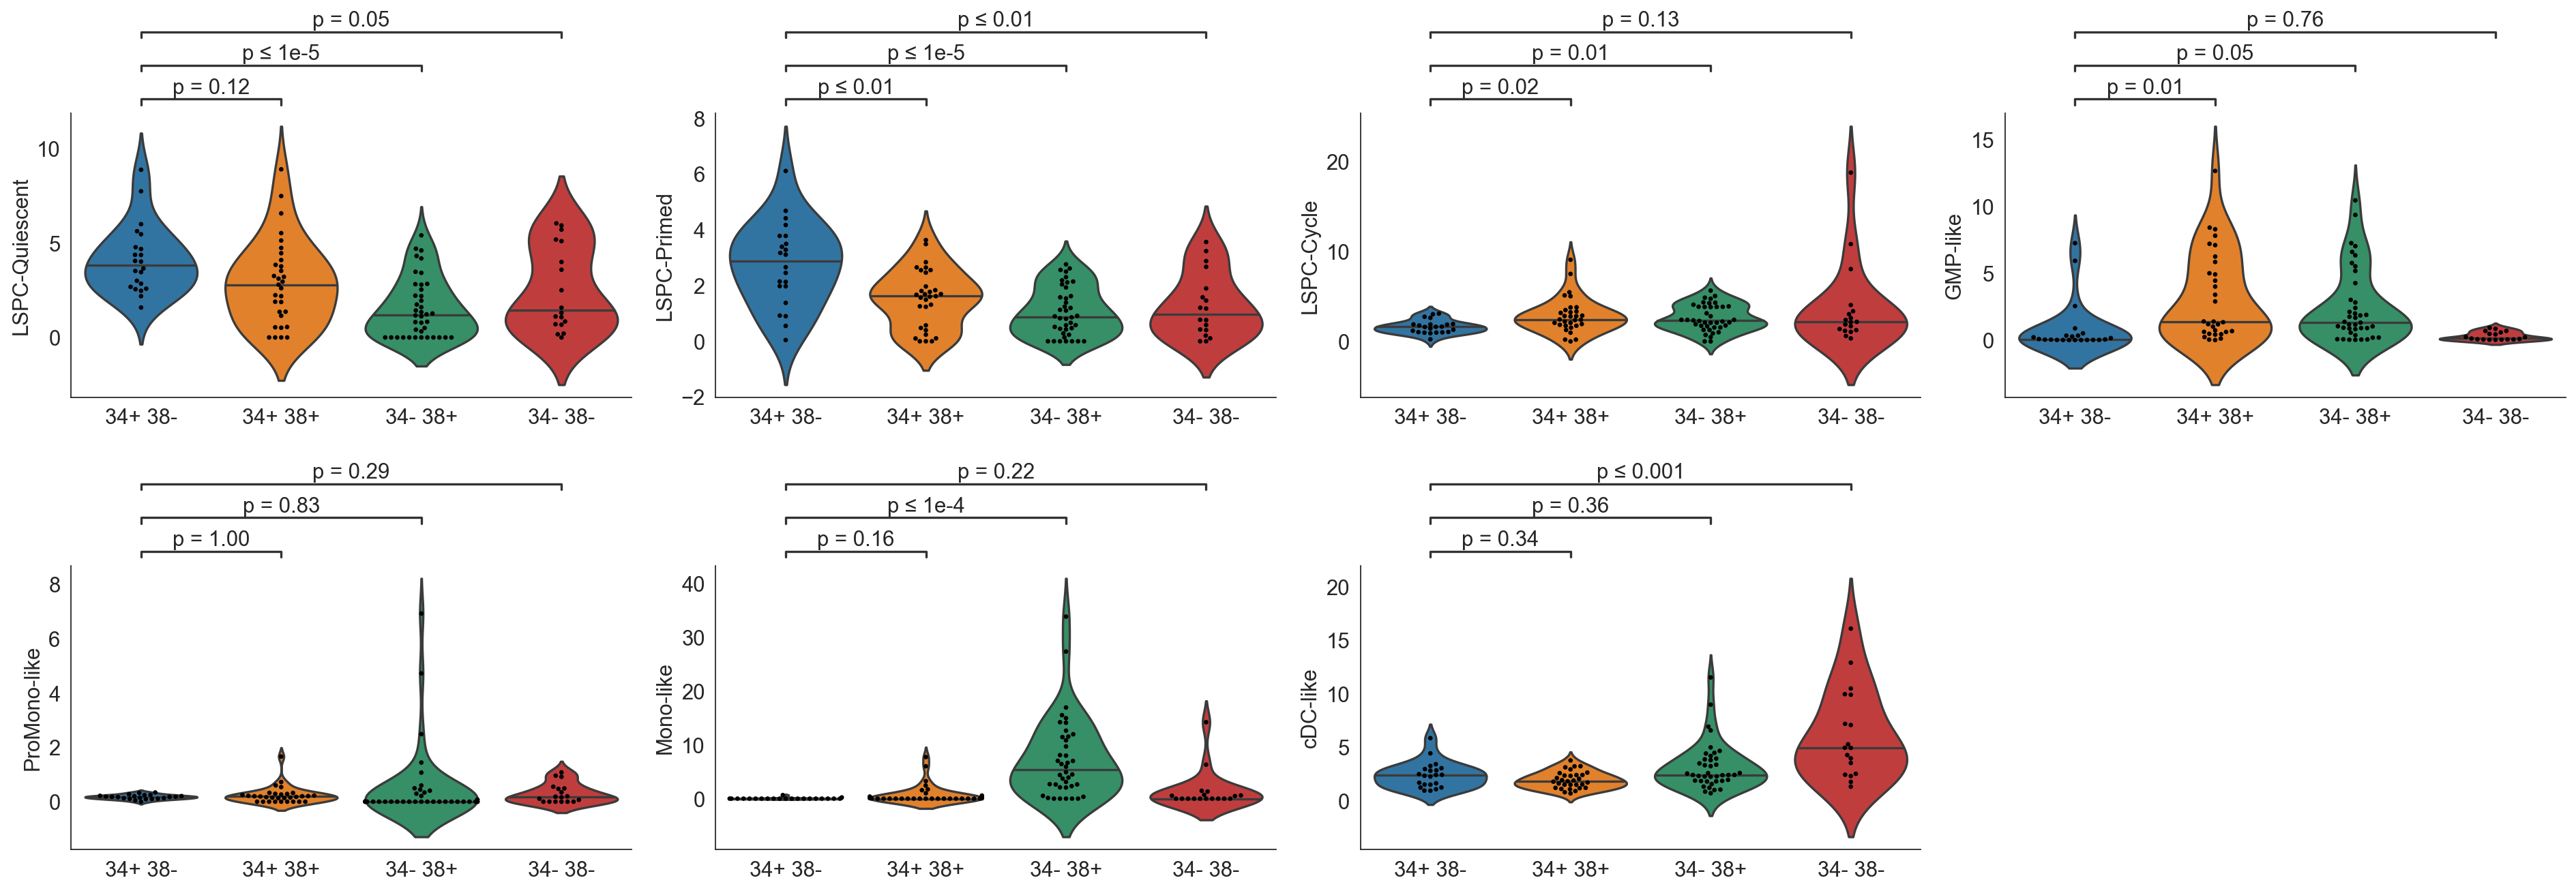

In [7]:
sns.set_style('white')
plt.figure(figsize=[24, 8.5])
plt.subplot(2,4,1)
violin_category(lsc, 'Fraction', 'LSPC-Quiescent-Absolute', xlab='', ylab='LSPC-Quiescent', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)
plt.subplot(2,4,2)
violin_category(lsc, 'Fraction', 'LSPC-Primed-Absolute', xlab='', ylab='LSPC-Primed', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)
plt.subplot(2,4,3)
violin_category(lsc, 'Fraction', 'LSPC-Cycle-Absolute', xlab='', ylab='LSPC-Cycle', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)
plt.subplot(2,4,4)
violin_category(lsc, 'Fraction', 'GMP-like-Absolute', xlab='', ylab='GMP-like', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)

plt.subplot(2,4,5)
violin_category(lsc, 'Fraction', 'ProMono-like-Absolute', xlab='', ylab='ProMono-like', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)
plt.subplot(2,4,6)
violin_category(lsc, 'Fraction', 'Mono-like-Absolute', xlab='', ylab='Mono-like', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)
plt.subplot(2,4,7)
violin_category(lsc, 'Fraction', 'cDC-like-Absolute', xlab='', ylab='cDC-like', 
                   order=['34+ 38-', '34+ 38+', '34- 38+', '34- 38-'], boxpairlist=[('34+ 38-', '34+ 38+'), ('34+ 38-', '34- 38+'), ('34+ 38-', '34- 38-')], textformat='simple', swarmsize=3)

plt.tight_layout()

### Plot cell type enrichment across functionally annotated LSC+ and LSC- fractions

In [8]:
lsc.obs['LSC Activity'] = np.where(lsc.obs['LSC status'] == '+', "LSC +\n(Engrafting)", 
                              np.where(lsc.obs['LSC status'] == '-', "LSC -\n(Non-Engrafting)", lsc.obs['LSC status']))
lsc.obs['LSC Activity'] = lsc.obs['LSC Activity'].str.replace('(','').str.replace(')','')

/Users/andyzeng/opt/anaconda3/envs/singlecell/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


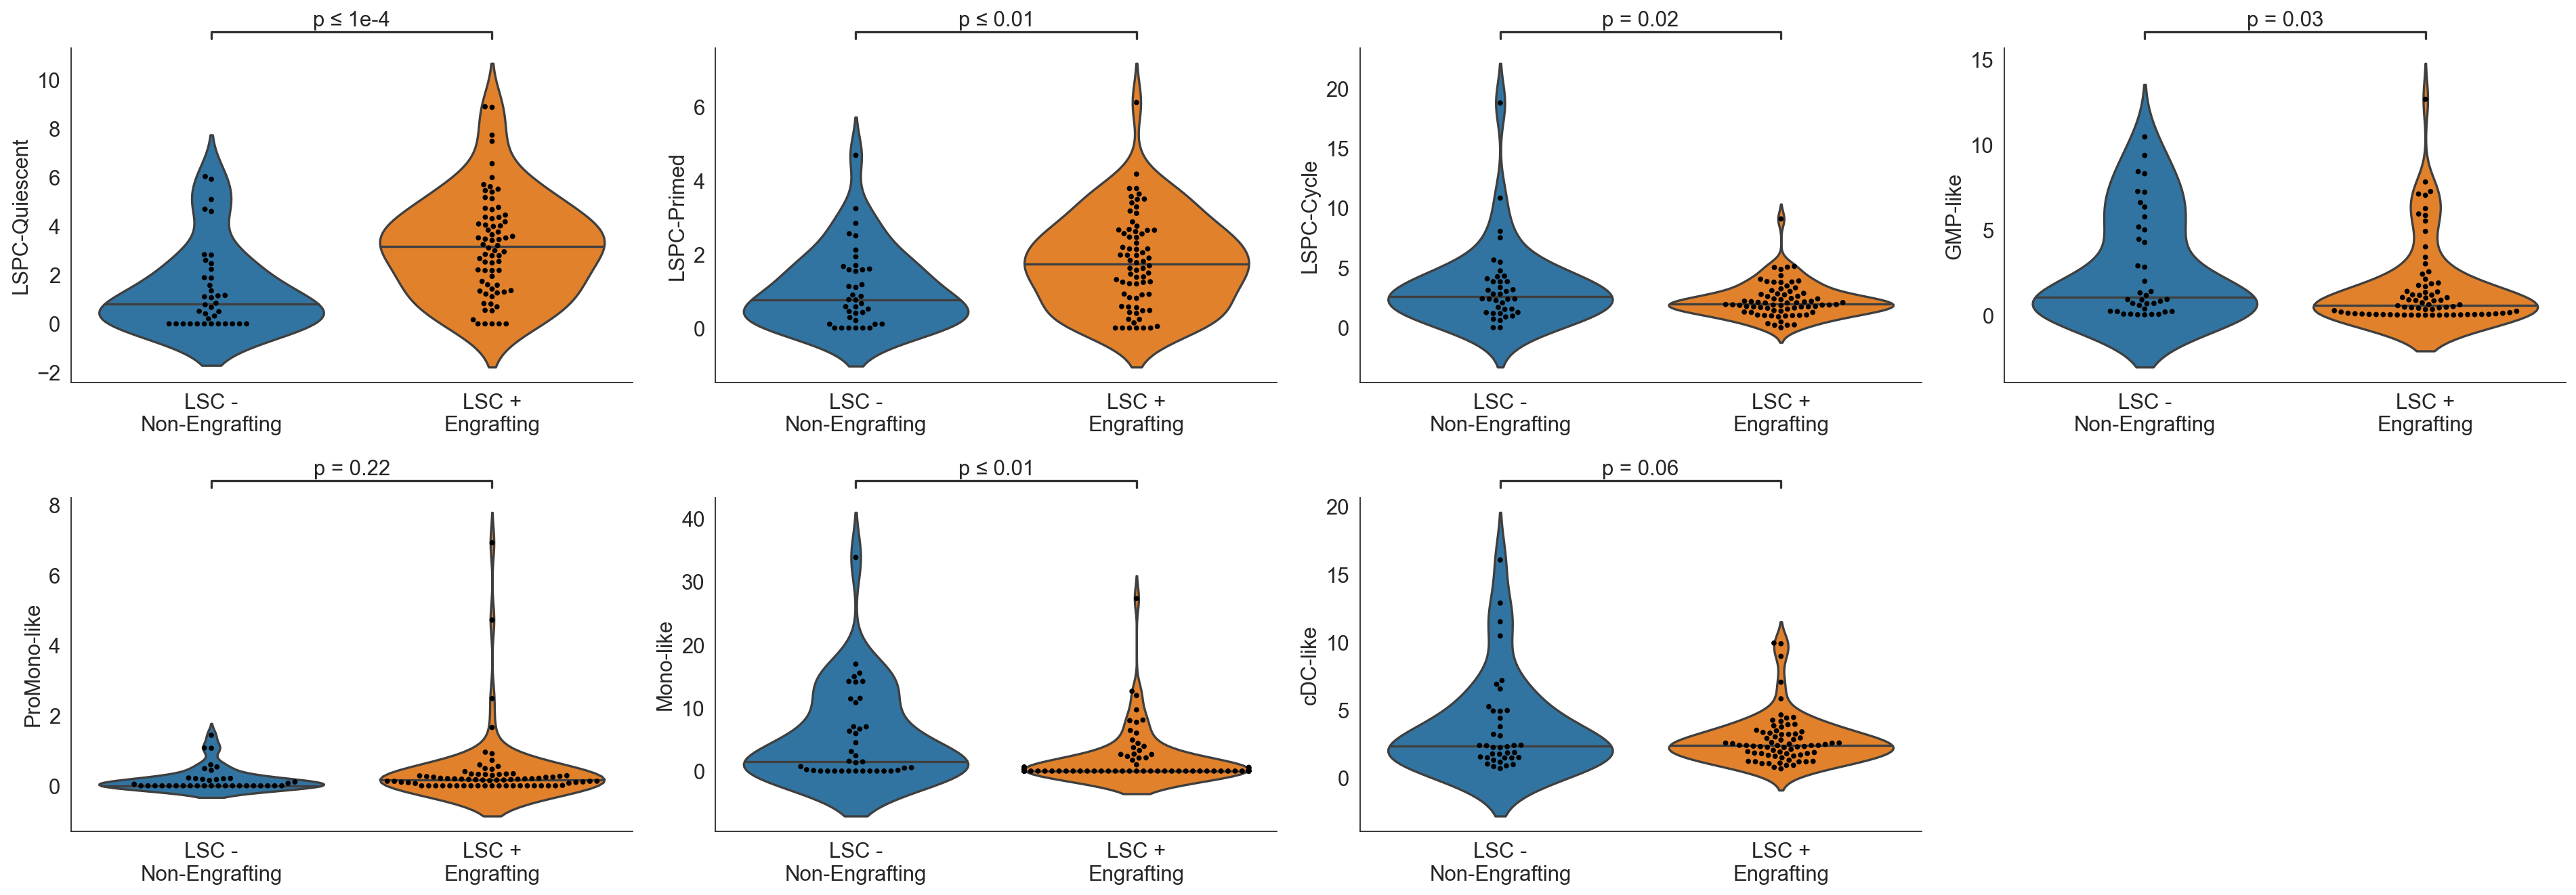

In [9]:
plt.figure(figsize=[24, 8.5])
plt.subplot(2,4,1)
violin_category(lsc, 'LSC Activity', 'LSPC-Quiescent-Absolute', xlab='', ylab='LSPC-Quiescent', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)
plt.subplot(2,4,2)
violin_category(lsc, 'LSC Activity', 'LSPC-Primed-Absolute', xlab='', ylab='LSPC-Primed', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)
plt.subplot(2,4,3)
violin_category(lsc, 'LSC Activity', 'LSPC-Cycle-Absolute', xlab='', ylab='LSPC-Cycle', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)
plt.subplot(2,4,4)
violin_category(lsc, 'LSC Activity', 'GMP-like-Absolute', xlab='', ylab='GMP-like', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)

plt.subplot(2,4,5)
violin_category(lsc, 'LSC Activity', 'ProMono-like-Absolute', xlab='', ylab='ProMono-like', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)
plt.subplot(2,4,6)
violin_category(lsc, 'LSC Activity', 'Mono-like-Absolute', xlab='', ylab='Mono-like', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)
plt.subplot(2,4,7)
violin_category(lsc, 'LSC Activity', 'cDC-like-Absolute', xlab='', ylab='cDC-like', 
                   order=['LSC -\nNon-Engrafting', 'LSC +\nEngrafting'], boxpairlist=[('LSC -\nNon-Engrafting', 'LSC +\nEngrafting')], textformat='simple', swarmsize=3.5)

plt.tight_layout()

# Literature LSC-Enriched Fractions

In [42]:
def get_ranklist(dat, classification, cluster_A, cluster_B, test='wilcoxon'):
    
    adata = dat[dat.obs[classification].isin([cluster_A, cluster_B])]

    sc.tl.rank_genes_groups(adata, classification, method = test, n_genes=20000)
    sam_cat_DE_df = pd.concat(
            [pd.DataFrame(adata.uns['rank_genes_groups']['names']),
             pd.DataFrame(adata.uns['rank_genes_groups']['scores']),
             pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']),
             pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])],
        keys = ['names','scores','logfoldchanges', 'pvals'],axis=1)

    sam_cat_DE_df.columns = sam_cat_DE_df.columns.swaplevel(0, 1)
    sam_cat_DE_df.sort_index(axis=1,level=0,inplace=True)
    sam_cat_DE_df = sam_cat_DE_df[cluster_A][['names', 'scores', 'logfoldchanges', 'pvals']]

    return(sam_cat_DE_df)

In [43]:
def get_scores(df, dat, classification, cluster_A, cluster_B, cohort, drug, target):
    # Absolute Scores
        
    ## Wilcox
    temp = get_ranklist(dat, classification, cluster_A, cluster_B, test='wilcoxon')
    temp['Cohort'] = cohort
    temp['Drug'] = drug
    temp['Target'] = target
    temp['Test'] = 'wilcox'
    df = df.append(temp)
    
    return(df)

In [58]:
def paired_scores(df, dat, pt_id, fraction, group, groupA, groupB):
    from scipy.stats import wilcoxon
    pairs = dat.obs[[pt_id, group]+dat.obs.columns[dat.obs.columns.str.contains('Relative')].tolist()].pivot(index=pt_id, columns=group).dropna()
    for celltype in dat.obs.columns[dat.obs.columns.str.contains('Relative')].tolist(): 
        w,p = wilcoxon(pairs[celltype][groupA] - pairs[celltype][groupB], mode='approx') ## compatibility from previous scipy version
        lfc = np.log(np.mean(pairs[celltype][groupA]) / np.mean(pairs[celltype][groupB]))
        df = df.append(pd.DataFrame({"names":[celltype], 'logfoldchanges':[lfc], 'pvals':[p], 'Drug':[fraction], 'Test':['wilcox paired']}))

    return(df)

In [59]:
df = pd.DataFrame()

## GPR56

In [6]:
dat = load_fractions("Data/Fig1_SingleCell_LSC/CIBERSORTx_GPR56_Fractions.csv")
dat.X = (dat.X.transpose() / dat.X.sum(axis=1)).transpose()
dat.obs['CD34'] = np.where(dat.obs.index.str.contains("CD34plus"), "CD34+", "CD34-")
dat.obs['GPR56'] = np.where(dat.obs.index.str.contains("GPR56plus"), "GPR56+", "GPR56-")
dat.obs['Pt_Sample'] = [x[1] for x in dat.obs.index.str.split('_')]
dat.obs['Pt_Sample'] = dat.obs['Pt_Sample'].str.replace('GPR56min', '').str.replace('GPR56plus', '')
dat.obs['Pt_Sample'] = np.where(dat.obs['Pt_Sample'].isin(["B","C"]), '11H160-CD34plus', dat.obs['Pt_Sample'])

In [61]:
df = paired_scores(df, dat, 'Pt_Sample', 'GPR56+', 'GPR56', 'GPR56+', 'GPR56-')
df.tail(7).sort_values('pvals')

Sample size too small for normal approximation.


,names,logfoldchanges,pvals,Drug,Test
0,GMP-like-Relative,-0.653177,0.011719,GPR56+,wilcox paired
0,LSPC-Cycle-Relative,0.840889,0.011719,GPR56+,wilcox paired
0,LSPC-Quiescent-Relative,0.386336,0.011719,GPR56+,wilcox paired
0,ProMono-like-Relative,-1.234475,0.068704,GPR56+,wilcox paired
0,LSPC-Primed-Relative,0.322215,0.123485,GPR56+,wilcox paired
0,Mono-like-Relative,-3.283645,0.123485,GPR56+,wilcox paired
0,cDC-like-Relative,-0.073541,0.483840,GPR56+,wilcox paired


## NKG2D

In [9]:
dat = load_fractions("Data/Fig1_SingleCell_LSC/CIBERSORTx_NKG2D_Fractions.csv")
dat.X = (dat.X.transpose() / dat.X.sum(axis=1)).transpose()
dat.obs['Patient'] = [x[1] for x in dat.obs.index.str.split('_')]
dat.obs['Fraction'] = [x[-1] for x in dat.obs.index.str.split('_')]
dat.obs

,GMP-like-Absolute,LSPC-Cycle-Absolute,LSPC-Primed-Absolute,LSPC-Quiescent-Absolute,Mono-like-Absolute,ProMono-like-Absolute,cDC-like-Absolute,GMP-like-Relative,LSPC-Cycle-Relative,LSPC-Primed-Relative,LSPC-Quiescent-Relative,Mono-like-Relative,ProMono-like-Relative,cDC-like-Relative,Patient,Fraction
Sample,,,,,,,,,,,,,,,,
GSM3657651_9_34_minus_Nplus,0.967917,6.745416,2.095077,0.895062,16.958096,0.000000,19.909792,0.020347,0.141796,0.044041,0.018815,0.356477,0.000000,0.418525,9,Nplus
GSM3657652_9_34_minus_Nminus,7.289460,0.584589,2.469213,5.032337,0.009021,0.000000,2.672935,0.403679,0.032374,0.136741,0.278683,0.000500,0.000000,0.148023,9,Nminus
GSM3657653_10_34_minus_Nplus,0.000000,3.253433,1.262946,4.952331,12.525222,3.799331,12.494226,0.000000,0.084974,0.032986,0.129346,0.327136,0.099232,0.326327,10,Nplus
GSM3657654_10_34_minus_Nminus,0.995013,4.676029,2.844210,3.787972,0.176500,0.249635,4.413225,0.058043,0.272773,0.165915,0.220969,0.010296,0.014562,0.257442,10,Nminus
GSM3657655_11_34_minus_Nplus,10.990811,1.441052,1.105211,2.062675,9.190633,0.000000,8.805630,0.327146,0.042894,0.032897,0.061396,0.273563,0.000000,0.262103,11,Nplus
GSM3657656_11_34_minus_Nminus,7.039028,0.540240,3.880667,3.418196,0.151529,0.000000,5.512177,0.342668,0.026299,0.188915,0.166402,0.007377,0.000000,0.268339,11,Nminus
GSM3657657_33_34_minus_Nplus,0.909995,11.971667,0.000000,5.563260,19.374012,0.000000,8.458646,0.019664,0.258693,0.000000,0.120215,0.418648,0.000000,0.182781,33,Nplus
GSM3657658_33_34_minus_Nminus,14.723099,29.955481,0.974342,16.227945,0.052618,0.000000,10.048470,0.204539,0.416153,0.013536,0.225445,0.000731,0.000000,0.139597,33,Nminus
GSM3657659_34_34_minus_Nplus,0.000000,4.753008,0.000000,8.096590,11.159175,7.424423,6.374948,0.000000,0.125714,0.000000,0.214149,0.295153,0.196371,0.168613,34,Nplus


In [63]:
df = paired_scores(df, dat, 'Patient', 'NKG2D-', 'Fraction', 'Nminus', 'Nplus')
df.tail(7)

Sample size too small for normal approximation.


,names,logfoldchanges,pvals,Drug,Test
0,GMP-like-Relative,1.098890,0.043114,NKG2D-,wilcox paired
0,LSPC-Cycle-Relative,0.378796,0.345231,NKG2D-,wilcox paired
0,LSPC-Primed-Relative,1.815177,0.043114,NKG2D-,wilcox paired
0,LSPC-Quiescent-Relative,0.818636,0.043114,NKG2D-,wilcox paired
0,Mono-like-Relative,-4.301650,0.043114,NKG2D-,wilcox paired
0,ProMono-like-Relative,-2.798012,0.179712,NKG2D-,wilcox paired
0,cDC-like-Relative,-0.312457,0.224916,NKG2D-,wilcox paired


## CD34 / CD38

In [11]:
dat = load_fractions("Data/Fig1_SingleCell_LSC/CIBERSORTx_LSC_Fractions.csv")
dat = dat[:,~dat.var_names.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
dat.X = (dat.X.transpose() / dat.X.sum(axis=1)).transpose()
dat.obs['Fraction'] = [x[-1] for x in dat.obs.index.str.split('_')]
dat.obs['CD34+CD38-'] = np.where(dat.obs.Fraction == 'CD34pCD38m', 'CD34+CD38-', 'Other')
dat.obs['CD34+'] = np.where(dat.obs.Fraction.isin(['CD34pCD38m', 'CD34pCD38p']), 'CD34+', 'Other')
dat.obs

Trying to set attribute `.obs` of view, copying.


,B-Absolute,CTL-Absolute,GMP-like-Absolute,LSPC-Cycle-Absolute,LSPC-Primed-Absolute,LSPC-Quiescent-Absolute,Mono-like-Absolute,Monocyte-Absolute,NK-Absolute,Plasma-Absolute,...,GMP-like-Relative,LSPC-Cycle-Relative,LSPC-Primed-Relative,LSPC-Quiescent-Relative,Mono-like-Relative,ProMono-like-Relative,cDC-like-Relative,Fraction,CD34+CD38-,CD34+
Sample,,,,,,,,,,,,,,,,,,,,,
LSC0001_Bl_CD34mCD38m,0.424229,0.019086,0.238961,18.795918,0.401809,0.206428,0.474813,1.447356,0.233423,0.069807,...,0.010602,0.833882,0.017826,0.009158,0.021065,0.000000,0.107466,CD34mCD38m,Other,Other
LSC0001_Bl_CD34pCD38m,0.137161,0.892244,5.945861,1.027860,1.377448,2.679355,0.000000,0.398436,0.019347,0.148736,...,0.425800,0.073608,0.098643,0.191876,0.000000,0.007131,0.202942,CD34pCD38m,CD34+CD38-,CD34+
LSC0001_Bl_CD34pCD38p,0.079102,0.528855,8.309251,1.530146,0.104221,1.354740,0.000000,0.399566,0.020331,0.118868,...,0.638890,0.117651,0.008013,0.104165,0.000000,0.017213,0.114067,CD34pCD38p,Other,CD34+
LSC0002_Bl_CD34mCD38p,1.090392,0.949458,1.163102,4.258364,1.577820,0.000000,15.519322,1.874642,0.352317,0.636757,...,0.047666,0.174515,0.064662,0.000000,0.636009,0.000000,0.077147,CD34mCD38p,Other,Other
LSC0002_Bl_CD34pCD38m,0.204275,0.751188,7.265747,0.233498,0.043451,4.017636,0.000000,0.821984,0.013215,0.325132,...,0.513981,0.016518,0.003074,0.284209,0.000000,0.017519,0.164699,CD34pCD38m,CD34+CD38-,CD34+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSC0074_Bl_CD34pCD38p,0.209141,0.482849,6.263955,2.869937,1.804481,0.554446,0.278477,1.066228,0.011712,0.165253,...,0.487802,0.223495,0.140523,0.043177,0.021686,0.000000,0.083318,CD34pCD38p,Other,CD34+
LSC0076_Bl_CD34mCD38m,2.172230,1.129160,0.053284,0.598986,0.106550,1.111063,0.708282,6.191735,0.000000,0.133446,...,0.004081,0.045880,0.008161,0.085102,0.054251,0.000000,0.802525,CD34mCD38m,Other,Other
LSC0076_Bl_CD34mCD38p,0.652221,0.989573,2.001715,2.273849,0.448300,0.000000,7.026440,1.295971,0.482887,0.385136,...,0.107236,0.121815,0.024016,0.000000,0.376421,0.000000,0.370512,CD34mCD38p,Other,Other


In [65]:
df = get_scores(df, dat, 'CD34+CD38-', 'CD34+CD38-', 'Other', 'CD34+CD38- Fractions', 'CD34+CD38-', 'CD34+CD38-')
df.tail(7)

Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'Fraction' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'CD34+CD38-' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'CD34+' as categorical


,names,logfoldchanges,pvals,Drug,Test,scores,Cohort,Target
0,LSPC-Primed,1.490581,0.000003,CD34+CD38-,wilcox,4.660321,CD34+CD38- Fractions,CD34+CD38-
1,LSPC-Quiescent,1.189741,0.000009,CD34+CD38-,wilcox,4.438401,CD34+CD38- Fractions,CD34+CD38-
2,ProMono-like,-0.805492,0.339954,CD34+CD38-,wilcox,0.954256,CD34+CD38- Fractions,CD34+CD38-
3,cDC-like,-0.126746,0.441702,CD34+CD38-,wilcox,0.769323,CD34+CD38- Fractions,CD34+CD38-
4,LSPC-Cycle,-0.448305,0.147093,CD34+CD38-,wilcox,-1.449878,CD34+CD38- Fractions,CD34+CD38-
5,GMP-like,-1.207960,0.000324,CD34+CD38-,wilcox,-3.595105,CD34+CD38- Fractions,CD34+CD38-
6,Mono-like,-5.753485,0.000037,CD34+CD38-,wilcox,-4.127713,CD34+CD38- Fractions,CD34+CD38-


## Summarise Changes

In [71]:
# Negative log Pvalue in the direction of the change 
df['logPval_dir'] = np.where(df['logfoldchanges'] < 0, np.log(df['pvals']), -np.log(df['pvals']))
# Re-order cell types
df.names = df.names.str.replace('-Relative', '')
df['CellType'] = df['names'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])
# Create p-value and negative log pvalue matrices
df_logpval_dir = df.pivot(index='Drug', columns='names', values='logPval_dir')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T
df_pvalue = df.pivot(index='Drug', columns='names', values='pvals')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T

R[write to console]: corrplot 0.84 loaded



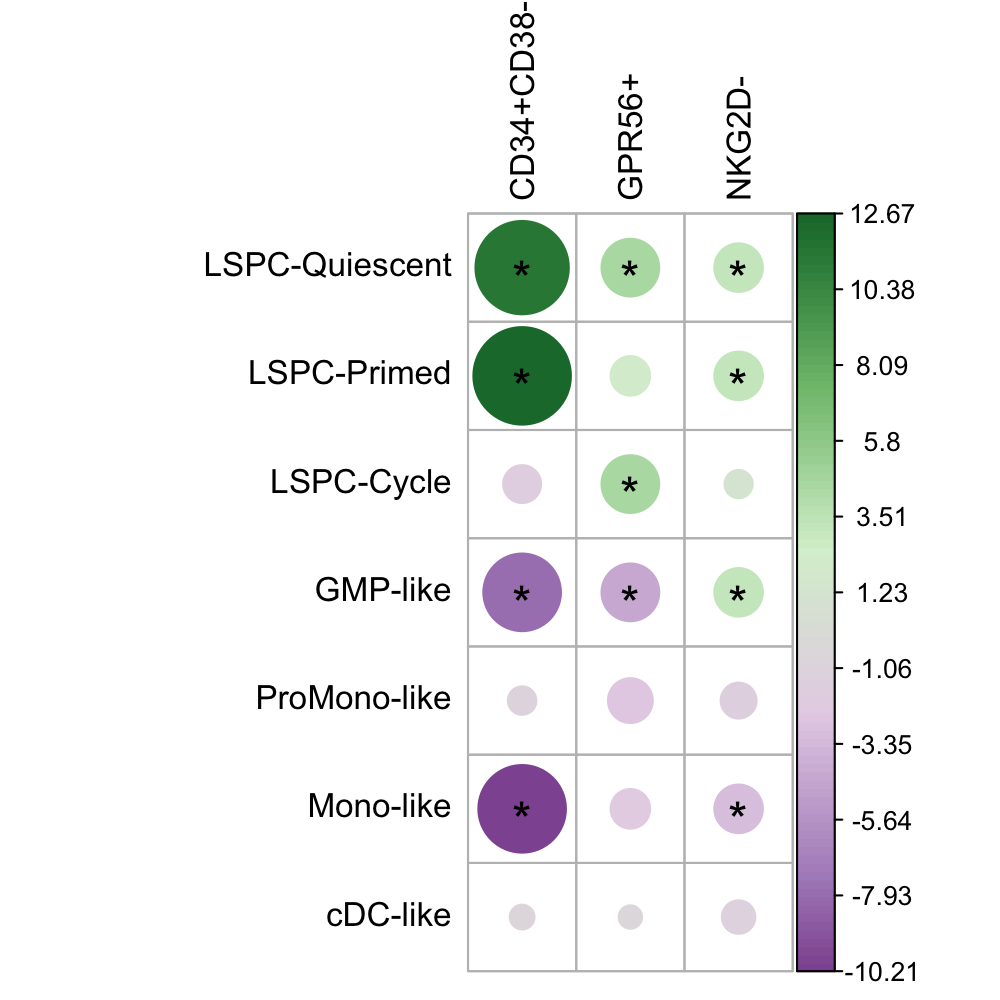

In [72]:
%%R -i df_logpval_dir -i df_pvalue -w 5 -h 5 --units in -r 200

library("corrplot")
library(RColorBrewer)

colors <- colorRampPalette(brewer.pal(6, 'PRGn'))
prgn_continuous <- colors(100)

df_logpval_dir %>% data.matrix() %>% corrplot(method = "circle", p.mat = data.matrix(df_pvalue),
                                        sig.level=0.05, insig = "label_sig", pch.col = "black", pch.cex = 1.5, 
                                        is.corr = FALSE, tl.col = 'black', col=prgn_continuous, cl.ratio=0.6) #c("pch", "p-value", "blank", "n", "label_sig"),) 

# Classifiers with Cell Type Composition + Fraction

**Build classifiers to predict LSC activity based on cell type enrichment and immunophenotypic fractions**

Compare average SHAP values across features to gauge relative importance for predicting LSC status

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## Classifiers

def evaluate_model(model, data_X, data_y, cohort):
    lblsu = np.unique(data_y)
    pred_y = model.predict(data_X)
    conf_mat = pd.DataFrame(confusion_matrix(data_y, pred_y))
    conf_mat.rename(columns={0:"Pred - "+lblsu[0], 1: "Pred - "+lblsu[1]}, 
                         index={0:"Actual - "+lblsu[0], 1: "Actual - "+lblsu[1]}, inplace=True)
    # Other metrics
    SP = conf_mat.iloc[0,0] / (conf_mat.iloc[0,0] + conf_mat.iloc[0,1]); SN = conf_mat.iloc[1,1] / (conf_mat.iloc[1,0] + conf_mat.iloc[1,1])
    Acc = (conf_mat.iloc[0,0] + conf_mat.iloc[1,1]) /  (conf_mat.iloc[0,0] + conf_mat.iloc[0,1] + conf_mat.iloc[1,0] + conf_mat.iloc[1,1])
    PPV = conf_mat.iloc[1,1] / (conf_mat.iloc[0,1] + conf_mat.iloc[1,1]); F1 = 2 * (PPV * SN) / (PPV + SN)

    print("\033[1m"+"\n\n##### "+cohort+" Results: ##########\n"+"\033[1m")
    print(conf_mat)
    print('\n\nSpecificity:\t' + '{:.3}'.format(SP),
          '\nSensitivity:\t' + '{:.3}'.format(SN),
          '\nPrecision:\t' + '{:.3}'.format(PPV))
    print('\nAccuracy:\t' + '{:.3}'.format(Acc),
          '\nF1 Score:\t' + '{:.3}'.format(F1))
    
    print(plot_roc_curve(model, data_X, data_y, name=cohort))
    
def train_logreg(X, y): 
    # get hold out dataset 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

    lr = LogisticRegression(penalty = 'l1', solver='liblinear', max_iter=1000)
    parameter_grid = {'class_weight' : ['balanced', None],
                      'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0]
                     }
    grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=10, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', **grid_search.best_params_)
    lr.fit(X_train, y_train)
    evaluate_model(lr, X_train, y_train, "Training")
    evaluate_model(lr, X_test, y_test, "Testing")
    return(lr)

def train_RandomForest(X, y):
    # get hold out dataset 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    param_grid = { 
        'n_estimators': [25, 50, 75, 100, 150],
        'max_depth': [1, 2, 3, 4]
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
    rf = RandomForestClassifier(n_jobs=-1, **grid_search.best_params_)
    rf.fit(X_train, y_train)
    evaluate_model(rf, X_train, y_train, "Training")
    evaluate_model(rf, X_test, y_test, "Testing")
    return(rf)

In [89]:
### Prep LSC fraction data.

# Remove multi-lineage engrafting fractions
lsc_noML = lsc[lsc.obs['LSC status'] != 'multilineage'].obs

# Re-format features to include cell type abundance and immunophenotypic fractions
x_frac4levels = lsc_noML[['LSPC-Quiescent-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Cycle-Absolute', 'GMP-like-Absolute', 'ProMono-like-Absolute', 'Mono-like-Absolute', 'cDC-like-Absolute', 'fraction']]
x_frac4levels = x_frac4levels.rename(columns={'fraction':'Fraction'})
x_frac4levels['Fraction'] = np.where(x_frac4levels['Fraction'] == 'CD34mCD38m', 0,
                                np.where(x_frac4levels['Fraction'] == 'CD34mCD38p', 1,
                                        np.where(x_frac4levels['Fraction'] == 'CD34pCD38p', 2,
                                                np.where(x_frac4levels['Fraction'] == 'CD34pCD38m', 3, np.nan))))

# LSC status 
y = lsc_noML['LSC status']
x_frac4levels.columns = x_frac4levels.columns.str.replace('-Absolute','')

## Random Forest Classifier

Best score: 0.8083333333333333
Best parameters: {'max_depth': 4, 'n_estimators': 150}


##### Training Results: ##########

            Pred - +  Pred - -
Actual - +        51         0
Actual - -         5        21


Specificity:	1.0 
Sensitivity:	0.808 
Precision:	1.0

Accuracy:	0.935 
F1 Score:	0.894


##### Testing Results: ##########

            Pred - +  Pred - -
Actual - +        18         3
Actual - -         8         4


Specificity:	0.857 
Sensitivity:	0.333 
Precision:	0.571

Accuracy:	0.667 
F1 Score:	0.421


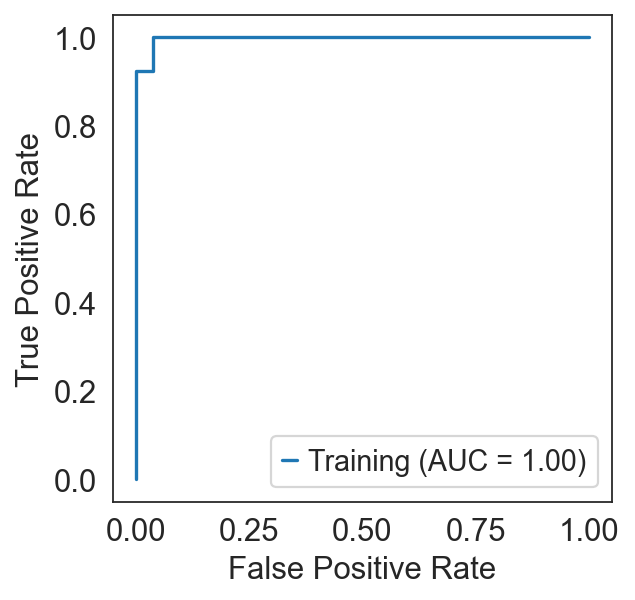

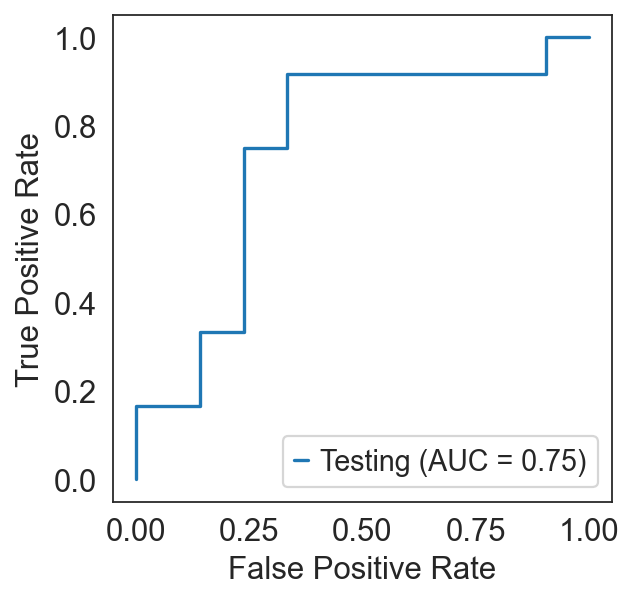

In [84]:
rf = train_RandomForest(x_frac4levels, y)

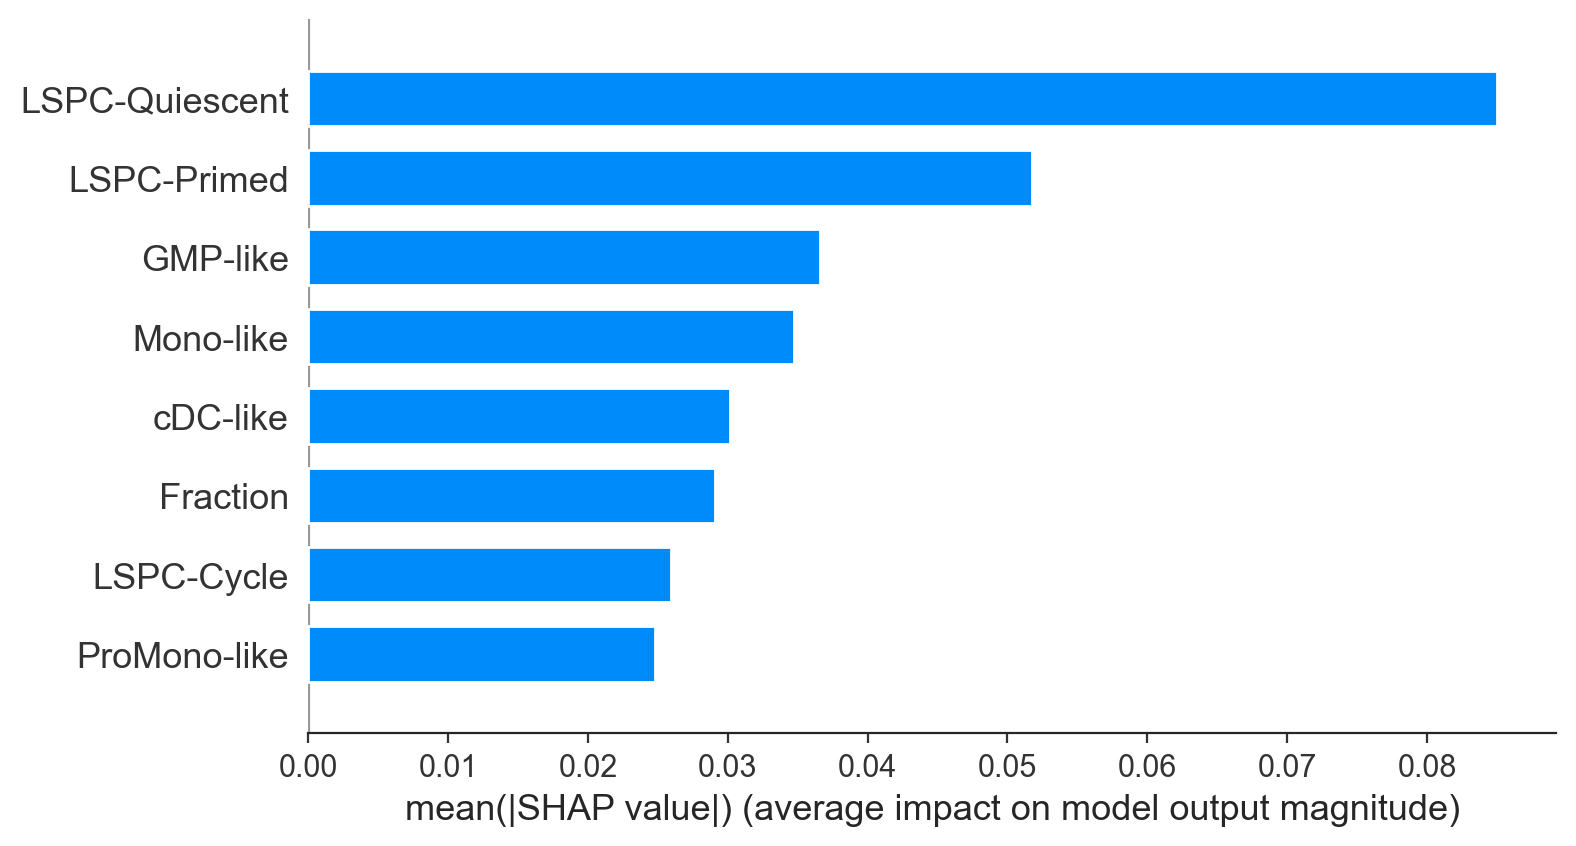

In [85]:
import shap 

explainer = shap.TreeExplainer(rf, x_frac4levels)
shap_values = explainer.shap_values(x_frac4levels)

plt.figure(figsize=(4, 4), dpi=100)
shap.summary_plot(shap_values[0], x_frac4levels, plot_type="bar", show=False, max_display=15)
plt.show()

## Logistic Regression Classifier

Best score: 0.7561111111111112
Best parameters: {'C': 1.0, 'class_weight': None}


##### Training Results: ##########

            Pred - +  Pred - -
Actual - +        48         6
Actual - -         9        19


Specificity:	0.889 
Sensitivity:	0.679 
Precision:	0.76

Accuracy:	0.817 
F1 Score:	0.717


##### Testing Results: ##########

            Pred - +  Pred - -
Actual - +        16         2
Actual - -         7         3


Specificity:	0.889 
Sensitivity:	0.3 
Precision:	0.6

Accuracy:	0.679 
F1 Score:	0.4


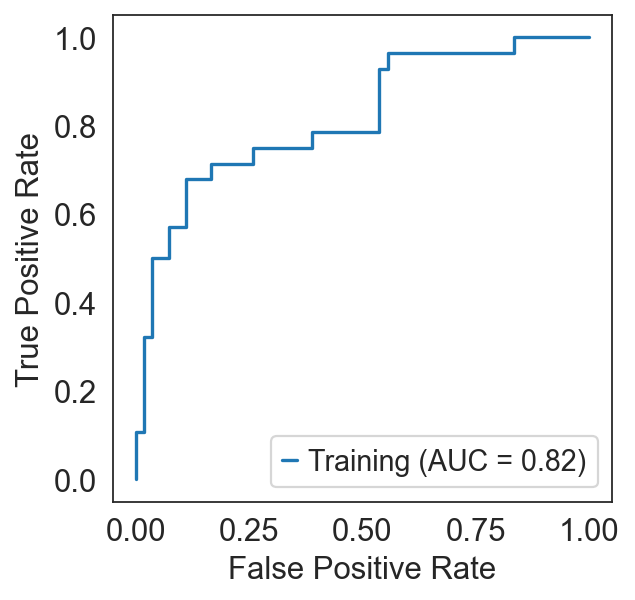

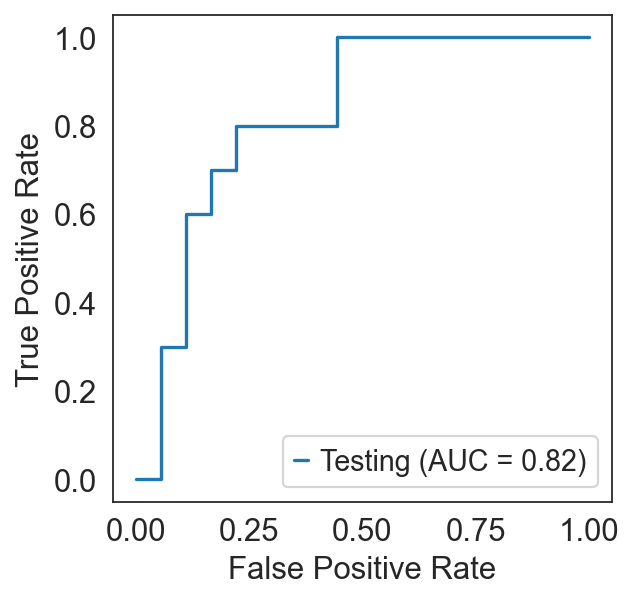

In [86]:
lr = train_logreg(x_frac4levels, y)

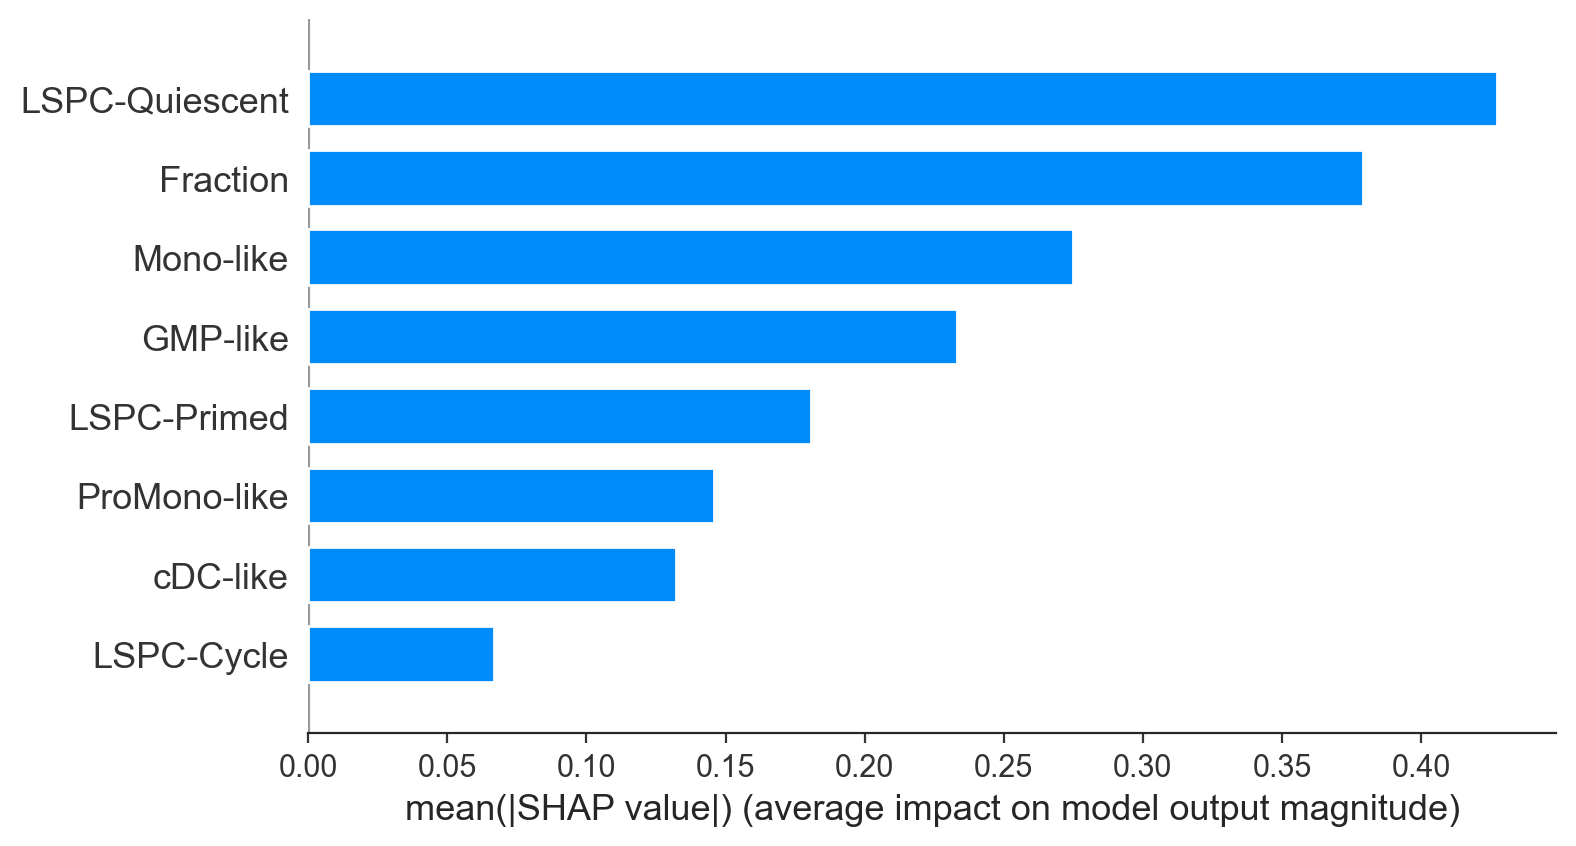

In [87]:
import shap 

explainer = shap.Explainer(lr, x_frac4levels)
shap_values = explainer.shap_values(x_frac4levels)

plt.figure(figsize=(4, 4), dpi=100)
p = shap.summary_plot(shap_values, x_frac4levels, plot_type="bar", show=False, max_display=10)
plt.show()